# Introduction

This notebook uses multidimensional scaling (MDS) to visualize the Dice distances term and structure occurrences in documents. Documents are colored by their domain assignments in each framework.

# Load the data

In [1]:
import pandas as pd
import sys
sys.path.append("..")
import utilities, mds

## Brain activation coordinates

In [2]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Term occurrences

In [3]:
frameworks = ["data-driven", "rdoc", "dsm"]
lists, words = {}, []
for framework in frameworks:
    lists[framework] = pd.read_csv("../ontology/lists/lists_{}{}.csv".format(framework, utilities.suffix[framework]), index_col=None)
    words += list(lists[framework]["TOKEN"])

In [4]:
words = sorted(list(set(words)))
len(words)

271

In [5]:
dtm_bin = utilities.load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Document dissimilarities

In [6]:
from scipy.spatial.distance import cdist

In [7]:
pmids = act_bin.index.intersection(dtm_bin.index)
len(pmids)

18155

In [8]:
act_bin = act_bin.loc[pmids]
dtm_bin = dtm_bin.loc[pmids]

In [9]:
vecs = act_bin.copy()
vecs[words] = dtm_bin[words]
vecs.shape

(18155, 385)

## Domain assignments

In [10]:
partitions = {framework: pd.read_csv("../partition/data/doc2dom_{}.csv".format(
                                     framework), index_col=0, header=None) - 1.0 
              for framework in frameworks}

# Fit the MDS model

In [11]:
import os
from sklearn.manifold import MDS

In [12]:
metric = True
eps = 0.001
max_iter = 5000

In [13]:
mds_model = MDS(n_components=2, max_iter=max_iter, metric=metric, eps=eps,
                dissimilarity="precomputed", random_state=42)

In [14]:
outfile = "data/mds_metric{}_eps{}_iter{}.csv".format(
          int(metric), eps, int(max_iter))
if not os.path.exists(outfile):
    print("Computing document distances")
    doc_dists = cdist(vecs, vecs, metric="dice")
    print("Fitting MDS model")
    X = mds_model.fit_transform(doc_dists)
    X_df = pd.DataFrame(X, index=vecs.index, columns=["X", "Y"])
    X_df.to_csv(outfile)
else:
    print("Loading MDS model")
    X = pd.read_csv(outfile, index_col=0, header=0).values

Loading MDS model


# Plot the results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
colors = {}
for framework in frameworks:
    colors[framework] = [utilities.palettes[framework][int(partitions[framework].loc[pmid])] 
                         for pmid in vecs.index]

In [17]:
shapes = {"data-driven": ["o", "v", "^", ">", "<", "s"],
          "rdoc": ["o", "v", "^", ">", "<", "s"],
          "dsm": ["o", "v", "^", ">", "<", "s", "X", "D", "p"]}

In [18]:
markers = {}
for framework in frameworks:
    markers[framework] = [shapes[framework][int(partitions[framework].loc[pmid])] 
                          for pmid in vecs.index]

## Data-driven

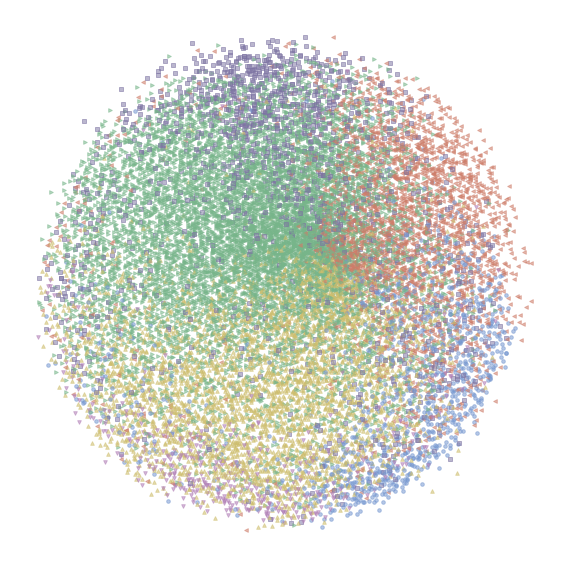

In [19]:
mds.plot_mds(X, "data-driven", colors, markers, metric, eps, max_iter)

## RDoC

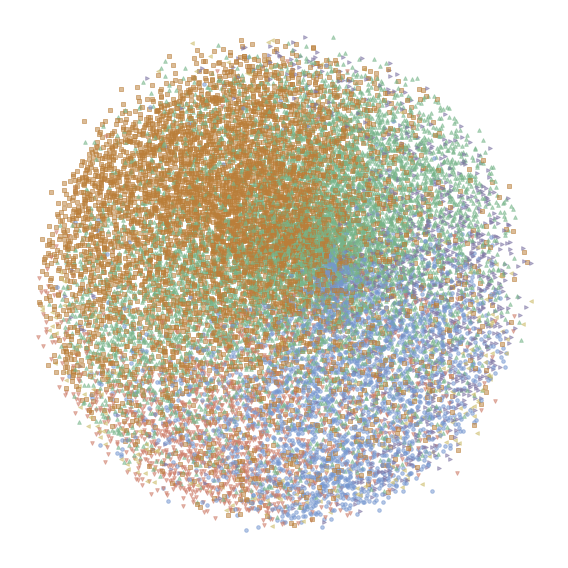

In [20]:
mds.plot_mds(X, "rdoc", colors, markers, metric, eps, max_iter)

## DSM

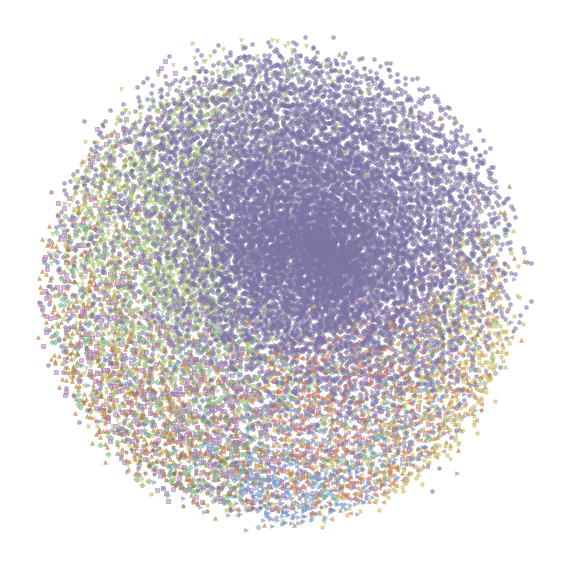

In [21]:
mds.plot_mds(X, "dsm", colors, markers, metric, eps, max_iter)